In [1146]:
numero=0#numero 34 lee una vez girada

#numero 35 llegeix malament, retalla massa 2354 HKR matricula 48#
#numero 31 no troba res 2304 LSC matricula 44#
#numero 29 no troba res 5317 JVW matricula 42
#numero 28 no troba res 3396 GDF matricula 41#
#numero 18 no troba res 7236 LFT matricula 3#
#numero 13 no troba res 3641 JGY matricula 24#
#numero 11 retalla malament 8234 MHS matricula 22#
#numero 8 llegeix regular (girada) 8425 MFR matricula 2#
#numero 7 regular la retallada 4674 FHC matricula 18#

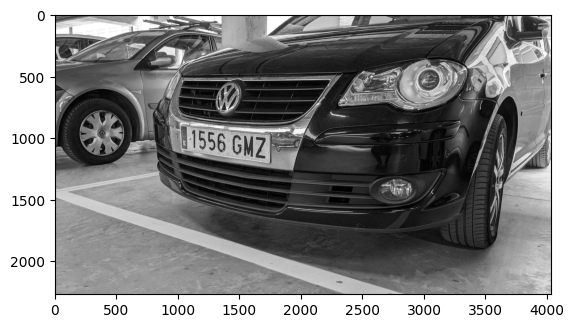

In [1147]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from skimage.segmentation import clear_border
import os
from sklearn.model_selection import train_test_split

path = os.getcwd()+"\\Imatges"

nom_imagenes = os.listdir(path)
imagenes = []
imagenes_b = []
ll_img = []

for titulo in nom_imagenes:
    
    if titulo.endswith('.jpg') or titulo.endswith('.jpeg'):
        img =  cv.imread('Imatges/' + titulo)
        ll_img.append(img)
        img_gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        b,g,r = cv.split(img)
        imagenes_b.append(b*0.6>img_gris)
        imagenes.append( img_gris)
       
Train=imagenes[:-6]
Test= imagenes[-6:]
#img = cv.imread('Imatges/matricula_28.jpeg')
#img_gris = cv.cvtColor(imagenes[0], cv.COLOR_BGR2GRAY)
plt.imshow(imagenes[numero], cmap="gray")

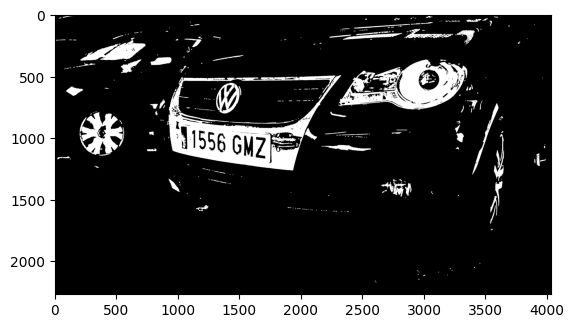

In [1148]:

imagenes_edge_removed = []

for imagen in  imagenes:
    
    median = cv.medianBlur(imagen, 3)
    ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
    edge_touching_removed = clear_border(opening)
    contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    imagenes_edge_removed.append(edge_touching_removed)

#median = cv.medianBlur(img_gris, 3)
#ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
#kernel = np.ones((5,5), np.uint8)
#opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
#edge_touching_removed = clear_border(opening)
#contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

plt.imshow(imagenes_edge_removed[numero], cmap="gray")

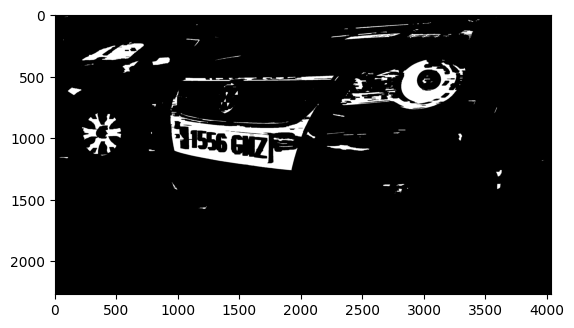

In [1149]:
#quitar linias finas elemento que cauan problemas
imagen_opening = []

for imagen in  imagenes_edge_removed:

    median = cv.medianBlur(imagen, 3)
    ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    img_erosion = cv.erode(th, kernel, iterations=4)
    opening = cv.morphologyEx(th, cv.MORPH_ERODE,  np.ones((1,30), np.uint8))
    imagen_opening.append(opening)


plt.imshow(imagen_opening[numero], cmap="gray")
#median = cv.medianBlur(imagen, 3)
#ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
#kernel = np.ones((3,3), np.uint8)0
#img_erosion = cv.erode(th, kernel, iterations=4)
#opening = cv.morphologyEx(th, cv.MORPH_ERODE,  np.ones((1,30), np.uint8))
#imagen_opening.append(opening)

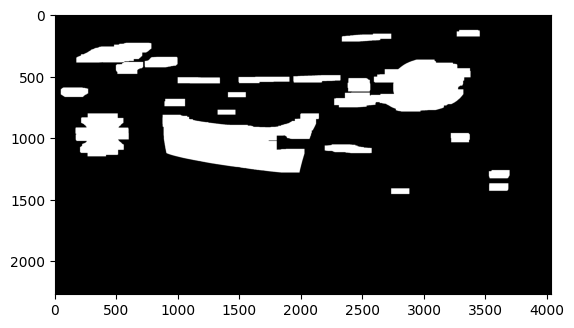

In [1150]:

imagenes_cnt = []

for imagen in imagen_opening:
    
    img_erosion = cv.erode(imagen, kernel, iterations=7)
    img_dilation = cv.dilate(img_erosion, kernel, iterations=7)
    img_dilation = cv.dilate(img_dilation, np.ones((2,9), np.uint8), iterations=15)
    img_dilation = cv.dilate(img_dilation, kernel, iterations=5)



    contour,hier = cv.findContours(img_dilation,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)

    for cnt in contour:
        cv.drawContours(img_dilation,[cnt],0,255,-1)

    gray = cv.bitwise_not(img_dilation)



    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    res = cv.morphologyEx(gray,cv.MORPH_OPEN,kernel)
    res = cv.bitwise_not(res)
    
    imagenes_cnt.append(res)

plt.imshow(imagenes_cnt[numero], cmap="gray")


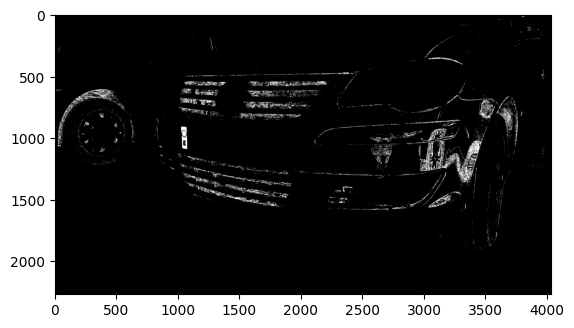

In [1151]:
#aqui canvia el codi:

plt.imshow(imagenes_b[numero], cmap="gray")

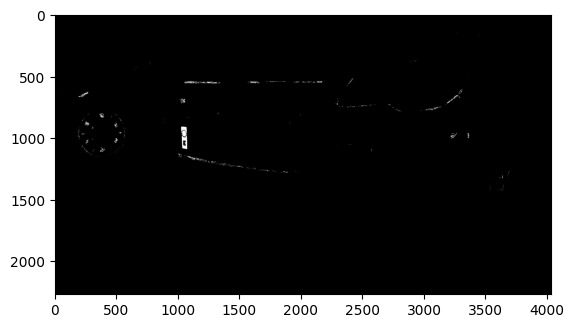

In [1152]:
plt.imshow(imagenes_b[numero]*imagenes_cnt[numero], cmap="gray")

In [1153]:
imagenes_combinadas=[]
for image_c,image_b in zip(imagenes_cnt,imagenes_b):
    comb=image_c*image_b
    comb = cv.erode(comb, kernel, iterations=5)
    comb = cv.dilate(comb, kernel, iterations=5)
    comb = cv.erode(comb, kernel, iterations=5)
    comb = cv.dilate(comb, kernel, iterations=5)
    #comb = cv.dilate(comb, np.ones((2,9), np.uint8), iterations=15)
    #comb = cv.dilate(comb, kernel, iterations=5)
    imagenes_combinadas.append(comb)
    

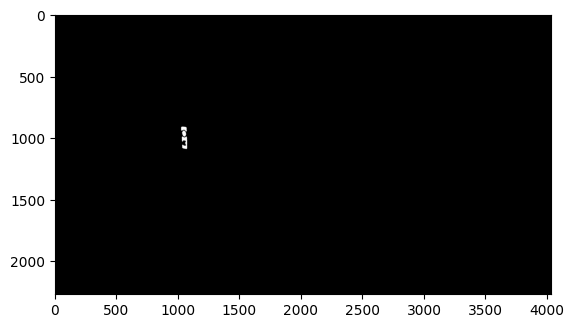

In [1154]:
plt.imshow(imagenes_combinadas[numero], cmap="gray")

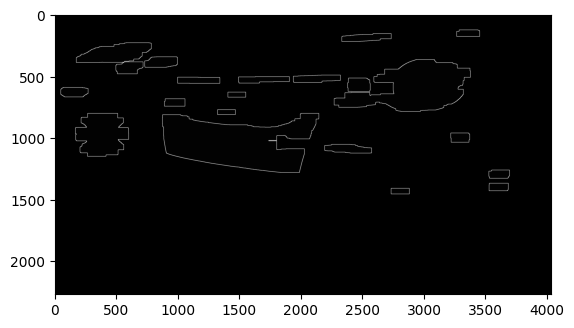

In [1155]:
ll_cnts = []
ll_contornos = []

for imagen in imagenes_cnt:

    cnts,_=cv.findContours(cv.Canny(imagen,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos =  cv.drawContours((imagen//255),cnts,-1,(100,100,100),2)
    ll_cnts.append(cnts)
    ll_contornos.append(contornos)
    
plt.imshow(ll_contornos[numero], cmap="gray")

In [1156]:
matricula_controno = []


for imagen,b in zip(ll_cnts,imagenes_combinadas):
    
    contornos_millor=imagen[0]
    area_max=0
    no_entrat=True
    for c in imagen:
        area = cv.contourArea(c)
        coord = cv.boundingRect(c)
        imagen_recortada = b[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
        
        if np.sum(imagen_recortada)>0 and area>area_max:#len(approx)==4 and area>4000:
            area_max=area
            contornos_millor=c
            no_entrat=False
    
    if no_entrat:     
        area_max=0
        for c in imagen:
            area = cv.contourArea(c)
            coord = cv.boundingRect(c)
            imagen_recortada = b[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
            
            if area>area_max:#len(approx)==4 and area>4000:
                area_max=area
                contornos_millor=c
            
    
    
    matricula_controno.append(contornos_millor)

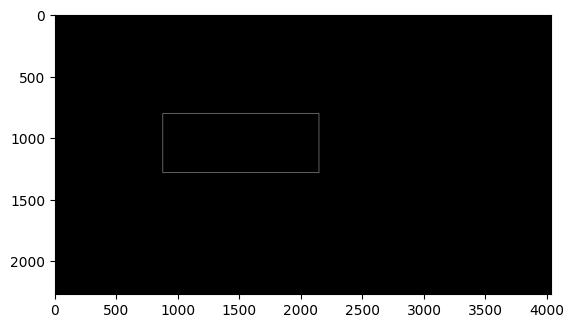

In [1157]:
ll_matricula  = []
ll_coord = []
for i, imagen in enumerate(matricula_controno):

    epsilon = 0.02*cv.arcLength(imagen,True)
    approx = cv.approxPolyDP(imagen,epsilon,True)
    #print(len(approx))
    x,y,w,h = cv.boundingRect(approx)
    ll_coord.append((x,y,w,h))    
    img = ll_img[i]
    rec = cv.rectangle(img//255,(x,y),(x+w,y+h),(255,255,255),2)
    ll_matricula.append(rec)
    

plt.imshow(ll_matricula[numero], cmap="gray")

In [1158]:
ll_recortadas = []

for  imagen, coord in zip(imagenes, ll_coord):
    
    imagen_recortada = imagen[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
    ll_recortadas.append(imagen_recortada)
    


#plt.imshow(ll_recortadas[numero],cmap="gray") 

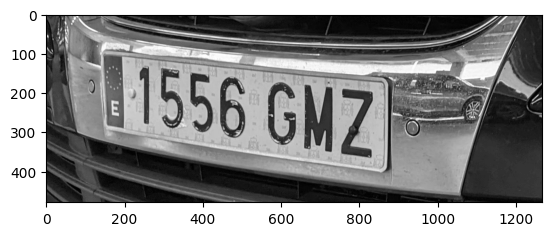

In [1159]:
plt.imshow(ll_recortadas[numero],cmap="gray") 

In [1160]:
def comprovador(texte):
    if len(texte)==7:
        if texte[0] in ("1234567890"):
            if texte[1] in ("1234567890"):
                if texte[2] in ("1234567890"):
                    if texte[3] in ("1234567890"):
                        if texte[4] in ("WRTYPSDFGHJKLZXCVBNM"):
                            if texte[5] in ("WRTYPSDFGHJKLZXCVBNM"):
                                if texte[6] in ("WRTYPSDFGHJKLZXCVBNM"):
                                    return True
    return False
    #comprova que esta be
    

In [1161]:
def netejar_lectura(ll_text):
    
    ll_resultat = []

    for text in ll_text:
        #separa per \n ?
         #identificar el punt mig entre nombres i lletres
         # tirar cap a la esquerra i dreta
         # comprovar
        matricula_bona=False
        matricula = ""
        uncleared_ll = list(text.lower())
        ll=[]
        for l in uncleared_ll:
            if l in ("1234567890wrtypsdfghjklzxcvbnm"):
                ll.append(l)
        
        mitjos=[]
        for (x,letra) in enumerate(ll[:-1]):
            if letra in ("1234567890")and x<len(ll):
                if ll[x+1] in ("wrtypsdfghjklzxcvbnm"):
                    mitjos.append(x)

        for punt in mitjos:
            try:
                if ll[punt-1] in ("1234567890"):
                    if ll[punt-2] in ("1234567890"):
                        if ll[punt-3] in ("1234567890"):
                            if ll[punt+2] in ("wrtypsdfghjklzxcvbnm"):
                                if ll[punt+3] in ("wrtypsdfghjklzxcvbnm"):
                                    matricula_bona=True
                                    matricula=ll[punt-3:punt+4]
                                    matricula=''.join(matricula).upper()
            except IndexError:
                pass
                #pass

        if not matricula_bona:
            count = 0
            ll = list(text.lower())
            matricula = ""

            for letra in ll:
                if count < 4:
                    if letra in ("1234567890"):
                        count += 1
                        matricula += letra
                    else:
                        count = 0
                elif count < 7:
                    if letra in ("wrtypsdfghjklzxcvbnm"):
                        count += 1
                        matricula += letra.upper()
              


        ll_resultat.append(matricula)
    return ll_resultat

In [1162]:
"""
ll_contornos_pequeño = []
cnt_pequeño = []

for  imagen in ll_recortadas:
    bi_matricula1, bi_matricula = cv.threshold(imagen, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    cnts_pequeño,_=cv.findContours(cv.Canny(bi_matricula,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos_pequeño =  cv.drawContours((imagen//255),cnts_pequeño,-1,(100,100,100),2)
    ll_contornos_pequeño.append(contornos_pequeño)
    cnt_pequeño.append(cnts_pequeño)
    
plt.imshow(ll_contornos_pequeño[numero], cmap="gray")"""

'\nll_contornos_pequeño = []\ncnt_pequeño = []\n\nfor  imagen in ll_recortadas:\n    bi_matricula1, bi_matricula = cv.threshold(imagen, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)\n    cnts_pequeño,_=cv.findContours(cv.Canny(bi_matricula,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)\n    contornos_pequeño =  cv.drawContours((imagen//255),cnts_pequeño,-1,(100,100,100),2)\n    ll_contornos_pequeño.append(contornos_pequeño)\n    cnt_pequeño.append(cnts_pequeño)\n    \nplt.imshow(ll_contornos_pequeño[numero], cmap="gray")'

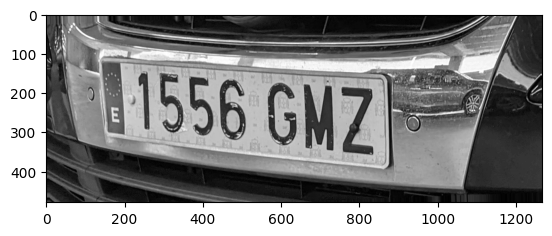

In [1163]:
ll_rotated = []

for  imagen_recortada in ll_recortadas:
    
    gray = cv.bitwise_not(imagen_recortada)
    thresh = cv.threshold(gray, 0, 255,	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    thresh = 255 - thresh
    

    cnts,_=cv.findContours(cv.Canny(thresh,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos_millor=cnts[0]
    area_max=0
    for c in cnts:
        area = cv.contourArea(c)
        if area>area_max:#len(approx)==4 and area>4000:
            area_max=area
            contornos_millor=c
            
    angle  = cv.minAreaRect(contornos_millor)[-1]

    if angle < -45:
        angle =  (90 + angle)
        
    
    else:
        angle = -( 90 - angle)
        

    (h, w) = imagen_recortada.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv.warpAffine(imagen_recortada, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    
    ll_rotated.append(rotated)
 
plt.imshow(ll_rotated[numero],cmap="gray")

In [1164]:
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

In [1165]:
"""
ll_text = []

for img_rotated in ll_rotated:
    text = pytesseract.image_to_string(img_rotated,config='--psm 11')
    ll_text.append(text)
    
    

print('PLACA: ',ll_text[numero])"""

"\nll_text = []\n\nfor img_rotated in ll_rotated:\n    text = pytesseract.image_to_string(img_rotated,config='--psm 11')\n    ll_text.append(text)\n    \n    \n\nprint('PLACA: ',ll_text[numero])"

In [1166]:
def girar(imagen_recortada):

    gray = cv.bitwise_not(imagen_recortada)
    thresh = cv.threshold(gray, 0, 255,	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    thresh = 255 - thresh
    

    cnts,_=cv.findContours(cv.Canny(thresh,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos_millor=cnts[0]
    area_max=0
    for c in cnts:
        area = cv.contourArea(c)
        if area>area_max:#len(approx)==4 and area>4000:
            area_max=area
            contornos_millor=c
            
    angle  = cv.minAreaRect(contornos_millor)[-1]

    if angle < -45:
        angle =  (90 + angle)
        
    
    else:
        angle = -( 90 - angle)
        

    (h, w) = imagen_recortada.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv.warpAffine(imagen_recortada, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return rotated

In [1167]:
ll_text = []

for img in ll_recortadas:
    text = pytesseract.image_to_string(img,config='--psm 11')
    ll_text.append(text)
ll_text[numero]

'—\n\nie\n\nt a\n\n——\n\n==\n\n—=\n\n—\n\n=e\n\nene\n\nOry\n\na\n\n+)\n\nean\n\nta\n\nZ\n\n155\n\nAig\n\n@\n\n—\n\n—\n'

In [1168]:
#list(ll_text[numero])

In [1170]:
ll_resultat = netejar_lectura(ll_text)
a_girar=[]
index=0
for resultat,imatge in zip(ll_resultat,ll_recortadas):
    if not comprovador(resultat):
        girada=girar(imatge)#girar imatge
        text = pytesseract.image_to_string(girada,config='--psm 11')#llegir
        text_netejat=netejar_lectura([text])[0]#netejar
        if comprovador(text_netejat):#compara
            ll_resultat[index]=text_netejat#substituiir si millor
        elif len(text_netejat)>len(resultat):#compara
            ll_resultat[index]=text_netejat#substituiir si millor
        else:
            pass   
    index+=1


In [1171]:
ll_resultat

['1556GMZ',
 '182',
 '3044JMB',
 '8929LKK',
 '3660CRT',
 '2344KJP',
 '0907JRF',
 '0012HLY',
 '6771MV',
 '',
 '1087MDR',
 '4236KMV',
 '652',
 '0214JWP',
 '6603DZM',
 '3467FPD',
 '8798GYS',
 '4840KHP',
 '1062FNT',
 '1943GFW',
 '2780KTT',
 '2968FZC',
 '2254HZL',
 '3678GXN',
 '',
 '4146HXM',
 '',
 '3044JMR',
 '9575LCM']

In [1172]:
ll_resultat[numero]

'1556GMZ'

In [1179]:
dic_y_gran = {'2': '8425MFR', '3':'2736LFT', '4':'5534HWK', '10':'1556GMZ', '11':'0182GLK', '12':'3044JMB', 
              '13':'6929LKK','14':'3660CRT', '15':'2344KJP', '16':'0907JRF', '17':'6401JBX', '18':'4674FHC', 
              '20':'0012HLY', '21':'7713MFV', '22':'8234MHS', '23':'1087MDR', '24':'3641JGY', '25':'4236KMV', 
              '26':'5652JTM', '27':'0214JWP', '28':'6603DZM', '29':'9058GMF', '30':'3467FPD', '32':'8798GYS', 
              '33':'4840KHP', '34':'1062FNT', '35':'1943GFW', '36':'2376CHN', '37':'2780KTT', '38':'2968FZC', 
              '39':'2254HZL', '40':'3678GXN', '41':'3396GDF', '42':'5317JVM', '43':'4146HXM', '44':'2304LSC', 
              '45':'0424JLP', '46':'3044JMB', '47':'9575LCM', '48':'2354HKR'}
dic_y = {'10':'1556GMZ', '11':'0182GLK', '12':'3044JMB', 
              '13':'6929LKK','14':'3660CRT', '15':'2344KJP', '16':'0907JRF',
              '20':'0012HLY', '21':'7713MFV', '22':'8234MHS', '23':'1087MDR','25':'4236KMV', 
              '26':'5652JTM', '27':'0214JWP', '28':'6603DZM','30':'3467FPD', '32':'8798GYS', 
              '33':'4840KHP', '34':'1062FNT', '35':'1943GFW','37':'2780KTT', '38':'2968FZC', 
              '39':'2254HZL', '40':'3678GXN', '42':'5317JVM', '43':'4146HXM',
              '45':'0424JLP', '46':'3044JMB', '47':'9575LCM',}


In [1180]:
path = os.getcwd()+"\\Imatges"
nom_imagenes = os.listdir(path)
ll_y = []
ll_titulos = []

for titulo in nom_imagenes:
    
    if titulo.endswith('.jpg') or titulo.endswith('.jpeg'):
        ll_titulos.append(titulo)
        img =  cv.imread('Imatges/' + titulo)
        ll_y.append(img)

In [1181]:
key = list(dic_y.keys())
key.sort()
ll_errores = []

for k, result in zip(key, ll_resultat):
    
    errores = 0
    for lletra_res, lletra_real in zip(result, dic_y[k]):
        if lletra_res != lletra_real:
            errores += 1
    ll_errores.append(errores)
print(ll_resultat)
print(ll_errores)
print(key)

['1556GMZ', '182', '3044JMB', '8929LKK', '3660CRT', '2344KJP', '0907JRF', '0012HLY', '6771MV', '', '1087MDR', '4236KMV', '652', '0214JWP', '6603DZM', '3467FPD', '8798GYS', '4840KHP', '1062FNT', '1943GFW', '2780KTT', '2968FZC', '2254HZL', '3678GXN', '', '4146HXM', '', '3044JMR', '9575LCM']
[0, 3, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
['10', '11', '12', '13', '14', '15', '16', '20', '21', '22', '23', '25', '26', '27', '28', '30', '32', '33', '34', '35', '37', '38', '39', '40', '42', '43', '45', '46', '47']


In [1183]:
key = list(dic_y.keys())
key.sort()
ll_errores = []

for k, result in zip(key, ll_resultat):
    print(result, dic_y[k])
print(len(ll_resultat))




1556GMZ 1556GMZ
182 0182GLK
3044JMB 3044JMB
8929LKK 6929LKK
3660CRT 3660CRT
2344KJP 2344KJP
0907JRF 0907JRF
0012HLY 0012HLY
6771MV 7713MFV
 8234MHS
1087MDR 1087MDR
4236KMV 4236KMV
652 5652JTM
0214JWP 0214JWP
6603DZM 6603DZM
3467FPD 3467FPD
8798GYS 8798GYS
4840KHP 4840KHP
1062FNT 1062FNT
1943GFW 1943GFW
2780KTT 2780KTT
2968FZC 2968FZC
2254HZL 2254HZL
3678GXN 3678GXN
 5317JVM
4146HXM 4146HXM
 0424JLP
3044JMR 3044JMB
9575LCM 9575LCM
29


In [ ]:
print(valors)

['1556GMZ', '0182GLK', '3044JMB', '6929LKK', '3660CRT', '2344KJP', '0907JRF', '6401JBX', '4674FHC', '8425MFR', '0012HLY', '7713MFV', '8234MHS', '1087MDR', '3641JGY', '4236KMV', '5652JTM', '0214JWP', '6603DZM', '9058GMF', '2736LFT', '3467FPD', '8798GYS', '4840KHP', '1062FNT', '1943GFW', '2376CHN', '2780KTT', '2968FZC', '2254HZL', '5534HWK', '3678GXN', '3396GDF', '5317JVM', '4146HXM', '2304LSC', '0424JLP', '3044JMB', '9575LCM', '2354HKR']
